In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
from itertools import chain
from typing import Iterable
from collections import Counter

import matplotlib.pyplot as plt
import torch

pd.set_option("max_colwidth", 800)

In [5]:
df = pd.read_csv('data/raw/us-city-place-names.csv', encoding='latin1')
df.sample(10)

,state_id,state_name,city
16645,21,Maryland,Adamstown
10288,16,Iowa,Nashua
40332,45,Texas,Fruitvale
26079,31,New Jersey,Seaside Park
31553,36,New York,Greene village
721,2,Alaska,Clear
18017,22,Louisiana,Benton
27503,33,New York,East Nassau
32876,37,North Carolina,Norlina
28552,33,New York,Verplanck


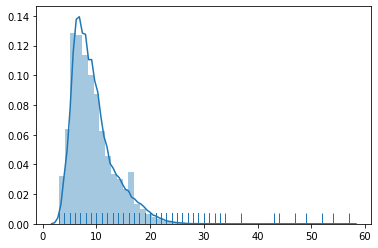

In [6]:
cities = df['city']
lens = [len(s) for s in cities]
sns.distplot(lens, rug=True)

In [7]:
sorted_by_len = np.argsort(lens)
cities.iloc[sorted_by_len[-10:]]

20048                            Chevy Chase Section Three village
30225                           Los Ranchos de Albuquerque village
7293                         Echols County consolidated government
16237                  Greeley County unified government (balance)
7327                  Georgetown-Quitman County unified government
7254               Cusseta-Chattahoochee County unified government
7151             Athens-Clarke County unified government (balance)
42659         Nashville-Davidson metropolitan government (balance)
17293       Louisville/Jefferson County metro government (balance)
7155     Augusta-Richmond County consolidated government (balance)
Name: city, dtype: object

In [8]:
cities.iloc[sorted_by_len[:10]]

47737    Roy
8958     Amo
39469    Eva
46081    Ona
31946    Ada
34392    Gap
46078    Odd
31813    Rye
35150    Rew
1495     Keo
Name: city, dtype: object

In [9]:
char_freq = Counter(chain(*cities))
sorted(char_freq.items(), key=lambda x: -x[1])

[('e', 44711),
 ('l', 38098),
 ('a', 37395),
 ('o', 32723),
 ('n', 30398),
 ('r', 29028),
 ('i', 28973),
 ('t', 21453),
 (' ', 17062),
 ('s', 16508),
 ('g', 11884),
 ('d', 11497),
 ('u', 10397),
 ('v', 10020),
 ('h', 9460),
 ('y', 7036),
 ('c', 6862),
 ('C', 6556),
 ('m', 6364),
 ('k', 5974),
 ('b', 5639),
 ('S', 5490),
 ('w', 5203),
 ('B', 4852),
 ('M', 4824),
 ('p', 3938),
 ('H', 3814),
 ('P', 3806),
 ('L', 3706),
 ('W', 3488),
 ('R', 2909),
 ('G', 2857),
 ('f', 2817),
 ('A', 2542),
 ('F', 2386),
 ('D', 2062),
 ('E', 1972),
 ('N', 1951),
 ('T', 1692),
 ('O', 1419),
 ('V', 1235),
 ('K', 1086),
 ('J', 838),
 ('x', 759),
 ('I', 705),
 ('z', 477),
 ('U', 353),
 ('Y', 234),
 ('q', 214),
 ('.', 165),
 ('Q', 123),
 ('Z', 92),
 ('-', 84),
 ('j', 67),
 ("'", 28),
 ('(', 15),
 (')', 15),
 ('X', 6),
 ('ñ', 3),
 ('/', 3)]

<BarContainer object of 60 artists>

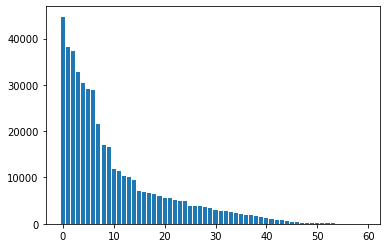

In [10]:
fig, ax = plt.subplots()
ax.bar(x=np.arange(len(char_freq)), height=sorted(char_freq.values(), reverse=True))

In [11]:
idx_to_drop = cities.str.contains(r'ñ|\/|\(|\)')
idx_to_drop.sum()

20

In [12]:
cities[idx_to_drop]

3299                                             Fredonia (Biscoe)
4160                               El Paso de Robles (Paso Robles)
4235                                          La Cañada Flintridge
4398                                    San Buenaventura (Ventura)
4874                                                    Cañon City
5051                                           Raymer (New Raymer)
5130                                             Milford (balance)
7151             Athens-Clarke County unified government (balance)
7155     Augusta-Richmond County consolidated government (balance)
13788                                       Indianapolis (balance)
16237                  Greeley County unified government (balance)
17293       Louisville/Jefferson County metro government (balance)
25497                                   Butte-Silver Bow (balance)
30199                                                     Española
40771                                       Naval Air Station/

In [18]:
cleaned_cities = cities[~idx_to_drop]
cleaned_cities

0         Abbeville
1          Abernant
2        Adamsville
3           Addison
4             Adger
            ...    
48736     Wamsutter
48737     Wheatland
48738       Worland
48739        Wright
48740         Yoder
Name: city, Length: 48721, dtype: object

In [21]:
with open('data/interim/cleaned.txt', 'wt') as f:
    f.write('\n'.join(cleaned_cities))

In [14]:
class CharacterTokenizer:
    SOS_TOKEN = '<s>'
    EOS_TOKEN = '<s/>'
    PAD_TOKEN = '<pad>'
        
    def fit(self, X:Iterable[str]):
        self.idx2tok = [self.PAD_TOKEN, self.SOS_TOKEN, self.EOS_TOKEN]        
        characters = sorted(set(chain(*X)))
        self.idx2tok += characters        
        self.tok2idx = {t: i for i, t in enumerate(self.idx2tok)}
        
    def __len__(self):
        return len(self.idx2tok)

    def get_vocab_size(self):
        return len(self.tok2idx)

    def encode(self, s: str, add_special_tokens=False) -> torch.LongTensor:
        if add_special_tokens:
            s = [self.SOS_TOKEN] + list(s) + [self.EOS_TOKEN]
        values = [self.tok2idx[c] for c in s]
        return torch.LongTensor(values)

    def decode(self, t: torch.LongTensor) -> str:
        decoded = [self.idx2tok[i] for i in t]
        return ''.join(decoded)
    
tokenizer = CharacterTokenizer()
tokenizer.fit(cleaned_cities)

In [15]:
encoded = tokenizer.encode('New York', add_special_tokens=True)
encoded

tensor([ 1, 20, 37, 55,  3, 31, 47, 50, 43,  2])

In [16]:
decoded = tokenizer.decode(encoded)
decoded

'<s>New York<s/>'

In [25]:
import torch
from torch.utils.data import Dataset
from pathlib import Path

class WordDataset(Dataset):
    def __init__(self, tokenizer, dset_path: Path = None):
        self.tokenizer = tokenizer
        dset_path = dset_path

        lines = []
        with dset_path.open('rt') as f:
            lines = [l.strip() for l in f.readlines()]
        self.lines = [l for l in lines if len(l) > 0]

    def __len__(self):
        return len(self.lines)

    def __getitem__(self, idx):
        x = self.lines[idx]
        y = self.lines[idx]

        x = self.tokenizer.encode(x, include_special_tokens=True)[:-1]
        y = self.tokenizer.encode(y, include_special_tokens=True)[1:]

        return x, y


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import torch.nn.utils.rnn as ru
from language_models.dataset.word import WordDataset
from torch.utils.data import random_split, DataLoader

from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

from argparse import Namespace
from language_models.tokenizer import FixedTokenizer
from pathlib import Path